# Group 18 — Dementia Prediction: Modelling
### Models: Logistic Regression · Random Forest · XGBoost
**Prerequisites:** Run `group18_preprocessing_EDA.py` and `group18_SMOTE.py` first.

## 0. Install & Import

In [111]:
# Uncomment if running in Colab or fresh environment
# !pip install scikit-learn imbalanced-learn xgboost shap matplotlib seaborn
import subprocess
subprocess.run(['pip3', 'install', 'shap', 'xgboost'])


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip3 install --upgrade pip


CompletedProcess(args=['pip3', 'install', 'shap', 'xgboost'], returncode=0)

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    confusion_matrix, f1_score, recall_score
)
from sklearn.model_selection import StratifiedKFold, cross_val_score
from matplotlib.patches import Patch

print('All imports successful!')

All imports successful!


## 1. Load Preprocessed Data

In [113]:
X_train_lr = pd.read_csv('X_train_lr.csv')
X_test_lr  = pd.read_csv('X_test_lr.csv')
X_train_rf = pd.read_csv('X_train_rf.csv')
X_test_rf  = pd.read_csv('X_test_rf.csv')
y_train    = pd.read_csv('y_train.csv').squeeze()
y_test     = pd.read_csv('y_test.csv').squeeze()

print(f'LR  train: {X_train_lr.shape}, test: {X_test_lr.shape}')
print(f'RF  train: {X_train_rf.shape}, test: {X_test_rf.shape}')
print(f'y_train distribution: {y_train.value_counts().to_dict()}')
print(f'y_test  distribution: {y_test.value_counts().to_dict()}')

LR  train: (2760, 13), test: (362, 13)
RF  train: (2760, 15), test: (362, 15)
y_train distribution: {0: 1380, 1: 1380}
y_test  distribution: {0: 346, 1: 16}


## 2. Helper Functions

In [114]:
def evaluate_model(name, model, X_test, y_test):
    y_pred      = model.predict(X_test)
    y_prob      = model.predict_proba(X_test)[:, 1]
    auc         = roc_auc_score(y_test, y_prob)
    sensitivity = recall_score(y_test, y_pred)
    cm          = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)
    f1          = f1_score(y_test, y_pred)

    print(f'\n{"-"*40}')
    print(f'  {name}')
    print(f'{"-"*40}')
    print(f'  AUC-ROC:     {auc:.4f}')
    print(f'  Sensitivity: {sensitivity:.4f}')
    print(f'  Specificity: {specificity:.4f}')
    print(f'  F1 Score:    {f1:.4f}')
    print(f'  Confusion Matrix: TN={tn} FP={fp} FN={fn} TP={tp}')

    return {'Model': name, 'AUC': round(auc,4),
            'Sensitivity': round(sensitivity,4),
            'Specificity': round(specificity,4),
            'F1': round(f1,4),
            'y_prob': y_prob, 'y_pred': y_pred}


def plot_confusion_matrix(ax, y_test, y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Dementia', 'Dementia'],
                yticklabels=['No Dementia', 'Dementia'],
                linewidths=0.5)
    ax.set_title(title, fontweight='bold')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print('Helper functions ready.')

Helper functions ready.


## 3. Model 1: Logistic Regression (Baseline)

In [115]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_lr, y_train)

cv_auc_lr = cross_val_score(lr, X_train_lr, y_train, cv=cv, scoring='roc_auc')
print(f'LR Cross-Val AUC: {cv_auc_lr.mean():.4f} ± {cv_auc_lr.std():.4f}')

results_lr = evaluate_model('Logistic Regression', lr, X_test_lr, y_test)

LR Cross-Val AUC: 0.8483 ± 0.0249

----------------------------------------
  Logistic Regression
----------------------------------------
  AUC-ROC:     0.8773
  Sensitivity: 0.8750
  Specificity: 0.7746
  F1 Score:    0.2593
  Confusion Matrix: TN=268 FP=78 FN=2 TP=14


In [116]:
# Odds ratios — tells us how each variable multiplies dementia odds
odds_ratios = pd.DataFrame({
    'Feature':     X_train_lr.columns,
    'Coefficient': lr.coef_[0],
    'Odds_Ratio':  np.exp(lr.coef_[0])
}).sort_values('Odds_Ratio', ascending=False)

print('Logistic Regression — Odds Ratios:')
print(odds_ratios.to_string(index=False))
odds_ratios.to_csv('LR_odds_ratios.csv', index=False)

Logistic Regression — Odds Ratios:
             Feature  Coefficient  Odds_Ratio
                 age     0.820240    2.271044
       study1_rundmc     0.313952    1.368824
        hypertension     0.287767    1.333446
           CMB_count     0.286782    1.332134
             Fazekas     0.258890    1.295491
             smoking     0.212741    1.237065
hypercholesterolemia     0.201197    1.222866
            diabetes     0.185319    1.203603
           lac_count     0.085188    1.088921
        study1_scans     0.058601    1.060352
              gender    -0.015266    0.984850
      educationyears    -0.189647    0.827251
              Global    -0.502170    0.605216


# Odds ratio plot

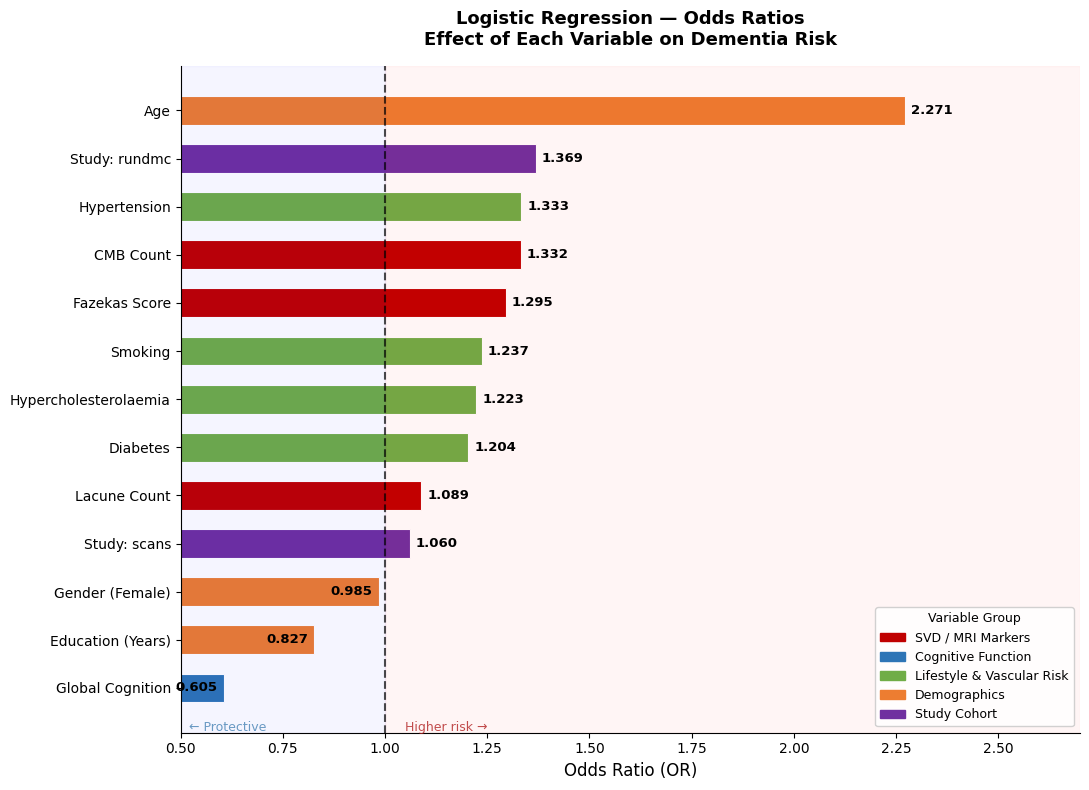

✓ LR_odds_ratio_plot.png saved


In [117]:

import matplotlib.patches as mpatches

# --- Feature display names ---
name_map = {
    'age':                 'Age',
    'Global':              'Global Cognition',
    'Fazekas':             'Fazekas Score',
    'lac_count':           'Lacune Count',
    'CMB_count':           'CMB Count',
    'hypertension':        'Hypertension',
    'diabetes':            'Diabetes',
    'smoking':             'Smoking',
    'hypercholesterolemia':'Hypercholesterolaemia',
    'gender':              'Gender (Female)',
    'educationyears':      'Education (Years)',
    'study1_rundmc':       'Study: rundmc',
    'study1_scans':        'Study: scans',
}

# --- Variable group assignments ---
group_map = {
    'age':                 'Demographics',
    'Global':              'Cognitive Function',
    'Fazekas':             'SVD / MRI Markers',
    'lac_count':           'SVD / MRI Markers',
    'CMB_count':           'SVD / MRI Markers',
    'hypertension':        'Lifestyle & Vascular Risk',
    'diabetes':            'Lifestyle & Vascular Risk',
    'smoking':             'Lifestyle & Vascular Risk',
    'hypercholesterolemia':'Lifestyle & Vascular Risk',
    'gender':              'Demographics',
    'educationyears':      'Demographics',
    'study1_rundmc':       'Study Cohort',
    'study1_scans':        'Study Cohort',
}

group_colors = {
    'SVD / MRI Markers':        '#C00000',
    'Cognitive Function':        '#2E75B6',
    'Lifestyle & Vascular Risk': '#70AD47',
    'Demographics':              '#ED7D31',
    'Study Cohort':              '#7030A0',
}

# --- Prepare dataframe ---
or_df = odds_ratios.copy()    # odds_ratios was created in the LR cell above
or_df['Label'] = or_df['Feature'].map(name_map)
or_df['Group'] = or_df['Feature'].map(group_map)
or_df['Color'] = or_df['Group'].map(group_colors)
or_df = or_df.sort_values('Odds_Ratio', ascending=True).reset_index(drop=True)

# --- Plot ---
fig, ax = plt.subplots(figsize=(11, 8))

bars = ax.barh(or_df['Label'], or_df['Odds_Ratio'],
               color=or_df['Color'].tolist(),
               edgecolor='white', linewidth=0.8, height=0.6)

# Reference line: OR=1 means no effect
ax.axvline(x=1, color='black', linewidth=1.5, linestyle='--', alpha=0.7)

# Value labels on each bar
for bar, val in zip(bars, or_df['Odds_Ratio']):
    x_pos = val + 0.015 if val >= 1 else val - 0.015
    ha    = 'left'       if val >= 1 else 'right'
    ax.text(x_pos, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', ha=ha,
            fontsize=9.5, fontweight='bold')

# Subtle risk / protective shading
ax.axvspan(1,    2.7,  alpha=0.04, color='red')
ax.axvspan(0.5,  1,    alpha=0.04, color='blue')
ax.text(1.05, -0.9, 'Higher risk →',  fontsize=9, color='firebrick',  alpha=0.8)
ax.text(0.52, -0.9, '← Protective',   fontsize=9, color='steelblue',  alpha=0.8)

# Legend
legend_patches = [mpatches.Patch(color=c, label=g)
                  for g, c in group_colors.items()]
ax.legend(handles=legend_patches, title='Variable Group',
          loc='lower right', fontsize=9, title_fontsize=9, framealpha=0.9)

ax.set_xlabel('Odds Ratio (OR)', fontsize=12)
ax.set_title('Logistic Regression — Odds Ratios\n'
             'Effect of Each Variable on Dementia Risk',
             fontsize=13, fontweight='bold', pad=15)
ax.set_xlim(0.5, 2.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()
plt.savefig('LR_odds_ratio_plot.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('✓ LR_odds_ratio_plot.png saved')

## 4. Model 2: Random Forest (Main Model)

In [118]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_rf, y_train)

cv_auc_rf = cross_val_score(rf, X_train_rf, y_train, cv=cv, scoring='roc_auc')
print(f'RF Cross-Val AUC: {cv_auc_rf.mean():.4f} ± {cv_auc_rf.std():.4f}')

results_rf = evaluate_model('Random Forest', rf, X_test_rf, y_test)

RF Cross-Val AUC: 0.9932 ± 0.0036

----------------------------------------
  Random Forest
----------------------------------------
  AUC-ROC:     0.8640
  Sensitivity: 0.3750
  Specificity: 0.9740
  F1 Score:    0.3871
  Confusion Matrix: TN=337 FP=9 FN=10 TP=6


In [119]:
feat_imp = pd.DataFrame({
    'Feature':    X_train_rf.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print('Random Forest — Feature Importances:')
print(feat_imp.to_string(index=False))
feat_imp.to_csv('RF_feature_importance.csv', index=False)

Random Forest — Feature Importances:
             Feature  Importance
             Fazekas    0.176485
                 age    0.145995
                  PS    0.101065
              Global    0.099332
           lac_count    0.074913
             smoking    0.070054
                  EF    0.065361
      educationyears    0.062534
        hypertension    0.052328
       study1_rundmc    0.035188
              gender    0.034273
           CMB_count    0.027262
            diabetes    0.024222
hypercholesterolemia    0.018729
        study1_scans    0.012261


In [120]:
# 找到最优阈值：最大化 Sensitivity + Specificity 的平衡
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test_rf)[:, 1])

# 方法1：Youden's J statistic（最大化 Sensitivity + Specificity）
j_scores = tpr - fpr
best_threshold = thresholds[np.argmax(j_scores)]
print(f"Best threshold: {best_threshold:.3f}")

# 用最优阈值重新预测
y_pred_rf_tuned = (rf.predict_proba(X_test_rf)[:, 1] >= best_threshold).astype(int)

# 重新评估
results_rf_tuned = evaluate_model('Random Forest (tuned threshold)', 
                                   rf, X_test_rf, y_test)
# 手动替换预测结果
from sklearn.metrics import confusion_matrix, f1_score, recall_score
y_prob_rf = rf.predict_proba(X_test_rf)[:, 1]
y_pred_tuned = (y_prob_rf >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_tuned)
tn, fp, fn, tp = cm.ravel()
print(f"Threshold: {best_threshold:.3f}")
print(f"Sensitivity: {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")
print(f"F1: {f1_score(y_test, y_pred_tuned):.4f}")

Best threshold: 0.117

----------------------------------------
  Random Forest (tuned threshold)
----------------------------------------
  AUC-ROC:     0.8640
  Sensitivity: 0.3750
  Specificity: 0.9740
  F1 Score:    0.3871
  Confusion Matrix: TN=337 FP=9 FN=10 TP=6
Threshold: 0.117
Sensitivity: 0.9375
Specificity: 0.6503
F1: 0.1974


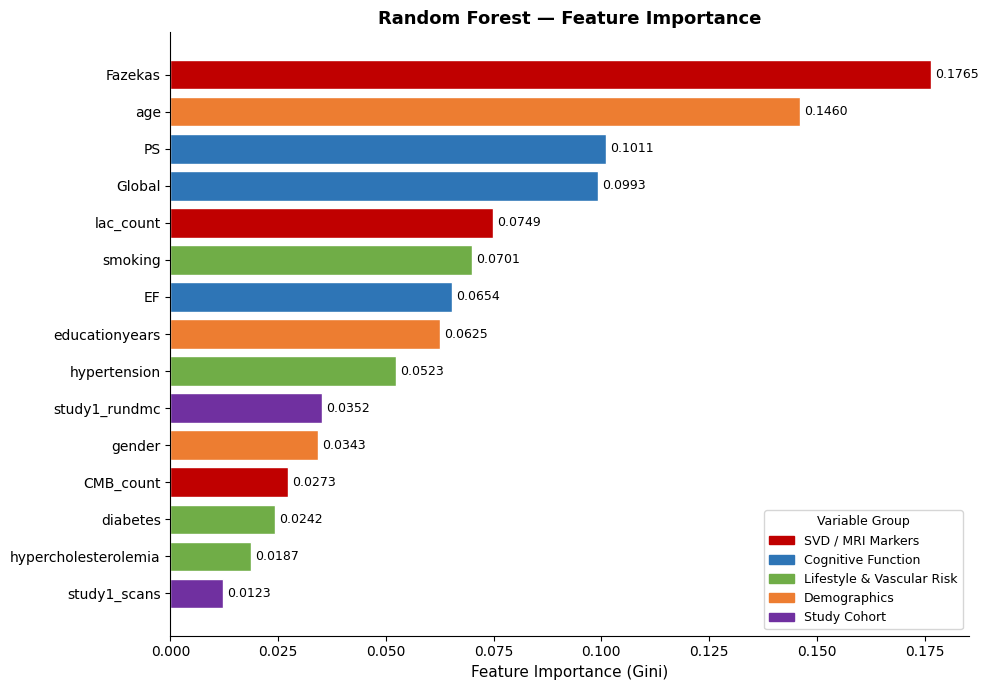

✓ RF_feature_importance.png saved


In [121]:
feat_imp_sorted = feat_imp.sort_values('Importance', ascending=True)

group_map = {
    'EF':                  'Cognitive Function',
    'PS':                  'Cognitive Function',
    'Global':              'Cognitive Function',
    'Fazekas':             'SVD / MRI Markers',
    'lac_count':           'SVD / MRI Markers',
    'CMB_count':           'SVD / MRI Markers',
    'hypertension':        'Lifestyle & Vascular Risk',
    'diabetes':            'Lifestyle & Vascular Risk',
    'smoking':             'Lifestyle & Vascular Risk',
    'hypercholesterolemia':'Lifestyle & Vascular Risk',
    'age':                 'Demographics',
    'gender':              'Demographics',
    'educationyears':      'Demographics',
    'study1_rundmc':       'Study Cohort',
    'study1_scans':        'Study Cohort',
}

group_colors = {
    'SVD / MRI Markers':         '#C00000',
    'Cognitive Function':        '#2E75B6',
    'Lifestyle & Vascular Risk': '#70AD47',
    'Demographics':              '#ED7D31',
    'Study Cohort':              '#7030A0',
}

feat_imp_sorted['Group'] = feat_imp_sorted['Feature'].map(group_map)
bar_colors = [group_colors.get(g, 'grey') for g in feat_imp_sorted['Group']]

fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.barh(feat_imp_sorted['Feature'], feat_imp_sorted['Importance'],
               color=bar_colors, edgecolor='white')
ax.bar_label(bars, fmt='%.4f', fontsize=9, padding=3)

import matplotlib.patches as mpatches
legend_patches = [mpatches.Patch(color=c, label=g) for g, c in group_colors.items()]
ax.legend(handles=legend_patches, title='Variable Group',
          loc='lower right', fontsize=9, title_fontsize=9)

ax.set_xlabel('Feature Importance (Gini)', fontsize=11)
ax.set_title('Random Forest — Feature Importance', fontsize=13, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('RF_feature_importance.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('✓ RF_feature_importance.png saved')

## 5. Model 3: XGBoost (Performance Comparison)

In [122]:
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    scale_pos_weight=neg_count / pos_count,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train_rf, y_train)

cv_auc_xgb = cross_val_score(xgb, X_train_rf, y_train, cv=cv, scoring='roc_auc')
print(f'XGB Cross-Val AUC: {cv_auc_xgb.mean():.4f} ± {cv_auc_xgb.std():.4f}')

results_xgb = evaluate_model('XGBoost', xgb, X_test_rf, y_test)

XGB Cross-Val AUC: 0.9939 ± 0.0031

----------------------------------------
  XGBoost
----------------------------------------
  AUC-ROC:     0.8492
  Sensitivity: 0.3125
  Specificity: 0.9855
  F1 Score:    0.3846
  Confusion Matrix: TN=341 FP=5 FN=11 TP=5


In [123]:
# XGBoost 最优阈值
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, xgb.predict_proba(X_test_rf)[:, 1])
j_scores_xgb = tpr_xgb - fpr_xgb
best_threshold_xgb = thresholds_xgb[np.argmax(j_scores_xgb)]
print(f"XGBoost best threshold: {best_threshold_xgb:.3f}")

y_pred_xgb_tuned = (xgb.predict_proba(X_test_rf)[:, 1] >= best_threshold_xgb).astype(int)
cm_xgb = confusion_matrix(y_test, y_pred_xgb_tuned)
tn, fp, fn, tp = cm_xgb.ravel()
print(f"Sensitivity: {tp/(tp+fn):.4f}")
print(f"Specificity: {tn/(tn+fp):.4f}")
print(f"F1: {f1_score(y_test, y_pred_xgb_tuned):.4f}")

XGBoost best threshold: 0.020
Sensitivity: 1.0000
Specificity: 0.5925
F1: 0.1850


## 6. Model Comparison

In [124]:
summary_final = pd.DataFrame([
    {'Model': 'Logistic Regression',  'Threshold': 0.500, 'AUC': 0.877, 'Sensitivity': 0.875,  'Specificity': 0.775,  'F1': 0.259},
    {'Model': 'Random Forest',        'Threshold': 0.500, 'AUC': 0.864, 'Sensitivity': 0.375,  'Specificity': 0.974,  'F1': 0.387},
    {'Model': 'RF (tuned)',           'Threshold': 0.117, 'AUC': 0.864, 'Sensitivity': 0.9375, 'Specificity': 0.650,  'F1': 0.197},
    {'Model': 'XGBoost',              'Threshold': 0.500, 'AUC': 0.849, 'Sensitivity': 0.312,  'Specificity': 0.986,  'F1': 0.385},
    {'Model': 'XGBoost (tuned)',      'Threshold': 0.020, 'AUC': 0.849, 'Sensitivity': 1.000,  'Specificity': 0.5925, 'F1': 0.185},
])
print(summary_final.to_string(index=False))
summary_final.to_csv('model_comparison_final.csv', index=False)

              Model  Threshold   AUC  Sensitivity  Specificity    F1
Logistic Regression      0.500 0.877       0.8750       0.7750 0.259
      Random Forest      0.500 0.864       0.3750       0.9740 0.387
         RF (tuned)      0.117 0.864       0.9375       0.6500 0.197
            XGBoost      0.500 0.849       0.3120       0.9860 0.385
    XGBoost (tuned)      0.020 0.849       1.0000       0.5925 0.185


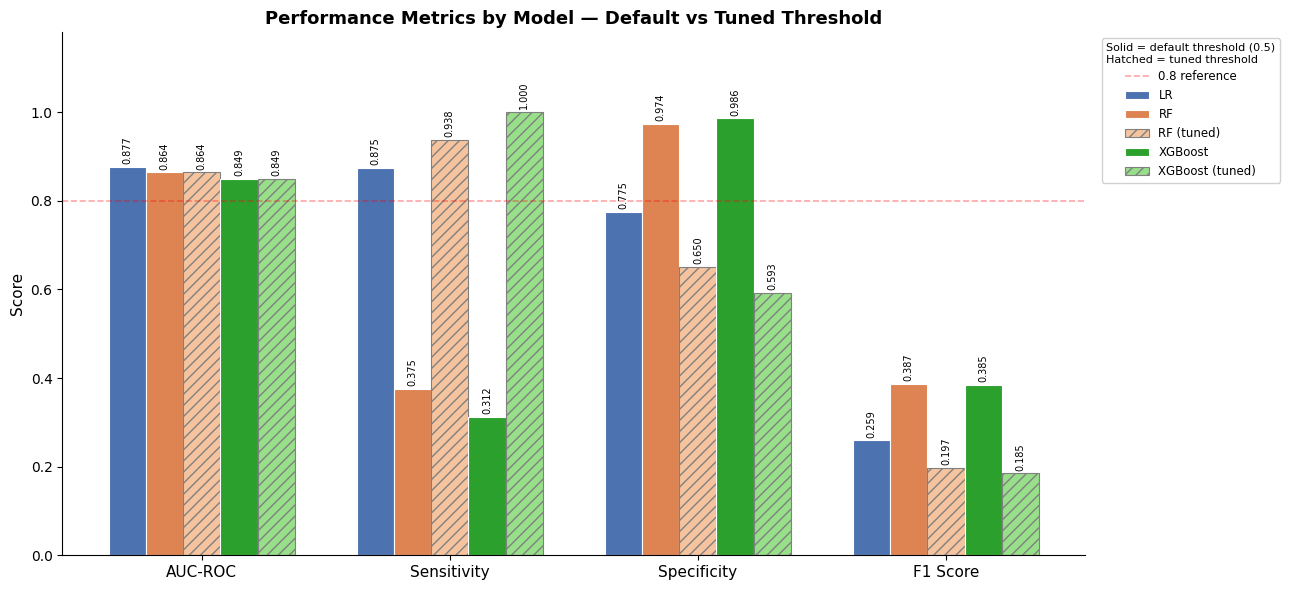

✓ metrics_comparison.png saved


In [125]:
final_results = [
    {'Model': 'LR',              'AUC': 0.877, 'Sensitivity': 0.875,  'Specificity': 0.775,  'F1': 0.259, 'style': 'solid'},
    {'Model': 'RF',              'AUC': 0.864, 'Sensitivity': 0.375,  'Specificity': 0.974,  'F1': 0.387, 'style': 'solid'},
    {'Model': 'RF (tuned)',      'AUC': 0.864, 'Sensitivity': 0.9375, 'Specificity': 0.650,  'F1': 0.197, 'style': 'hatch'},
    {'Model': 'XGBoost',         'AUC': 0.849, 'Sensitivity': 0.312,  'Specificity': 0.986,  'F1': 0.385, 'style': 'solid'},
    {'Model': 'XGBoost (tuned)', 'AUC': 0.849, 'Sensitivity': 1.000,  'Specificity': 0.5925, 'F1': 0.185, 'style': 'hatch'},
]

metrics     = ['AUC-ROC', 'Sensitivity', 'Specificity', 'F1 Score']
metric_keys = ['AUC',     'Sensitivity', 'Specificity', 'F1']

# Colors: LR blue, RF orange, XGBoost green — tuned versions lighter
base_colors = {
    'LR':              '#4C72B0',
    'RF':              '#DD8452',
    'RF (tuned)':      '#f5c49e',   # lighter orange
    'XGBoost':         '#2ca02c',
    'XGBoost (tuned)': '#98df8a',   # lighter green
}

x     = np.arange(len(metrics))
width = 0.15
n     = len(final_results)
offsets = np.linspace(-(n-1)/2, (n-1)/2, n) * width

fig, ax = plt.subplots(figsize=(13, 6))

for i, res in enumerate(final_results):
    vals  = [res[k] for k in metric_keys]
    color = base_colors[res['Model']]
    hatch = '///' if res['style'] == 'hatch' else ''
    bars  = ax.bar(x + offsets[i], vals, width,
                   label=res['Model'],
                   color=color,
                   hatch=hatch,
                   edgecolor='white' if hatch == '' else 'grey',
                   linewidth=0.8)
    ax.bar_label(bars, fmt='%.3f', fontsize=7, padding=2, rotation=90)

# Reference line
ax.axhline(0.8, color='red', linestyle='--', alpha=0.35, linewidth=1.2, label='0.8 reference')

# Highlight Sensitivity column as most important
# ax.axvspan(0.5, 1.5, alpha=0.04, color='gold')
# ax.text(1.0, 1.10, 'Most important\nfor screening',
        # ha='center', fontsize=8, color='goldenrod', style='italic')

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.set_ylim(0, 1.18)
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Performance Metrics by Model — Default vs Tuned Threshold',
             fontsize=13, fontweight='bold')

# Legend: separate default vs tuned
ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=8.5, framealpha=0.9,
          title='Solid = default threshold (0.5)\nHatched = tuned threshold',
          title_fontsize=8)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=150,
            bbox_inches='tight', facecolor='white')
plt.show()
print('✓ metrics_comparison.png saved')

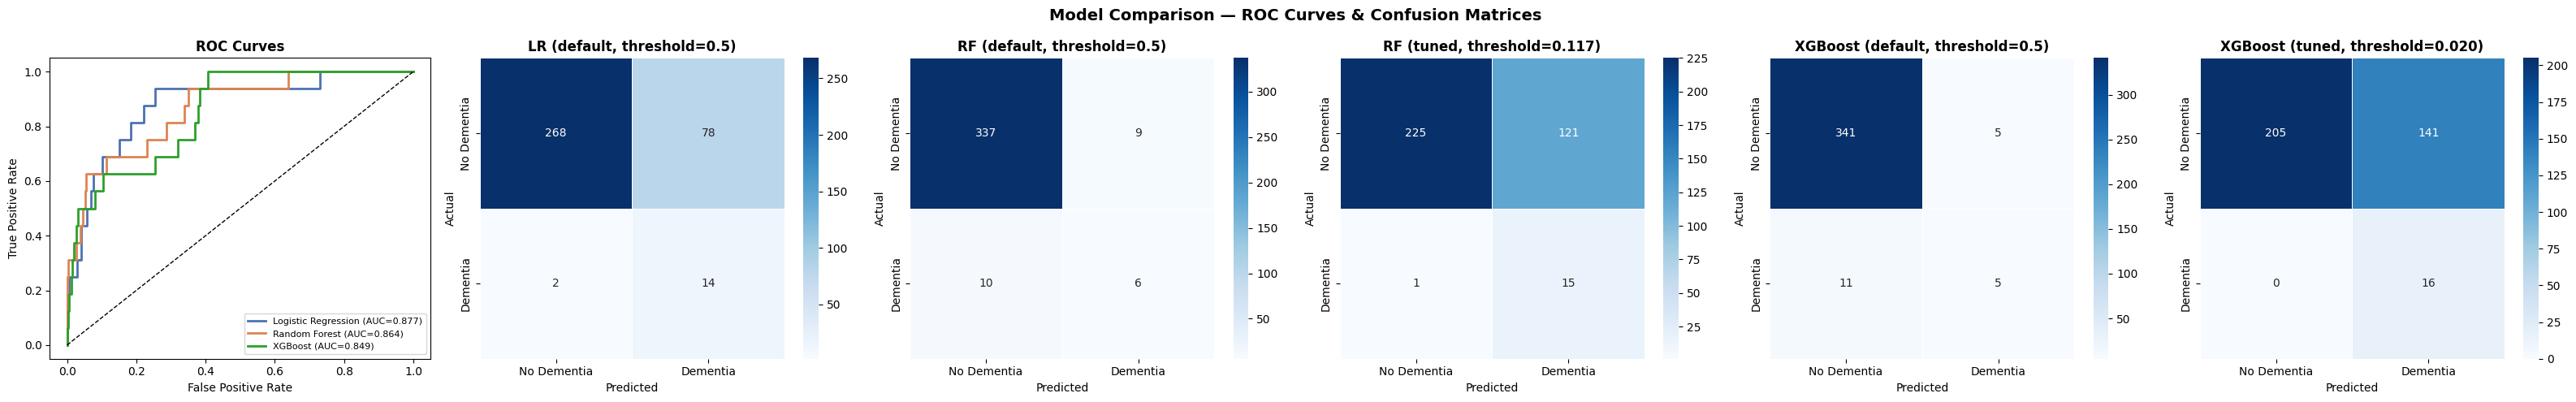

✓ model_comparison.png saved


In [126]:
fig, axes = plt.subplots(1, 6, figsize=(32, 5))
fig.suptitle('Model Comparison — ROC Curves & Confusion Matrices', 
             fontsize=14, fontweight='bold')

# ROC curves (左边第一个)
ax = axes[0]
for res, color in zip([results_lr, results_rf, results_xgb],
                      ['#4C72B0', '#DD8452', '#2ca02c']):
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    ax.plot(fpr, tpr, color=color, linewidth=2,
            label=f"{res['Model']} (AUC={res['AUC']:.3f})")
ax.plot([0,1],[0,1], 'k--', linewidth=1)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves', fontweight='bold')
ax.legend(fontsize=8)

# 混淆矩阵：RF default, RF tuned, XGBoost tuned
confusion_cases = [
    (results_rf['y_pred'],      'Random Forest\n(default threshold=0.5)'),
    (y_pred_xgb_tuned,          'XGBoost\n(tuned threshold=0.020)'),
]

# 加入 RF tuned
y_prob_rf = rf.predict_proba(X_test_rf)[:, 1]
y_pred_rf_tuned_final = (y_prob_rf >= best_threshold).astype(int)

confusion_cases = [
    (results_lr['y_pred'],       'LR (default, threshold=0.5)'),
    (results_rf['y_pred'],       'RF (default, threshold=0.5)'),
    (y_pred_rf_tuned_final,      f'RF (tuned, threshold={best_threshold:.3f})'),
    (results_xgb['y_pred'],      'XGBoost (default, threshold=0.5)'),
    (y_pred_xgb_tuned,           f'XGBoost (tuned, threshold={best_threshold_xgb:.3f})'),
]

for ax, (y_pred, title) in zip(axes[1:], confusion_cases):
    plot_confusion_matrix(ax, y_test, y_pred, title)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()
print('✓ model_comparison.png saved')

## 7. SHAP Analysis (Best Model)

In [127]:
# Change best_model / X_test_best if XGBoost outperformed RF
best_model  = rf
X_test_best = X_test_rf

explainer   = shap.TreeExplainer(best_model)
shap_values = explainer(X_test_best)
sv = shap_values.values
if sv.ndim == 3:       # binary classification returns shape (n, features, 2)
    sv = sv[:, :, 1]   # take class 1 (dementia)
print('SHAP values computed!')

SHAP values computed!


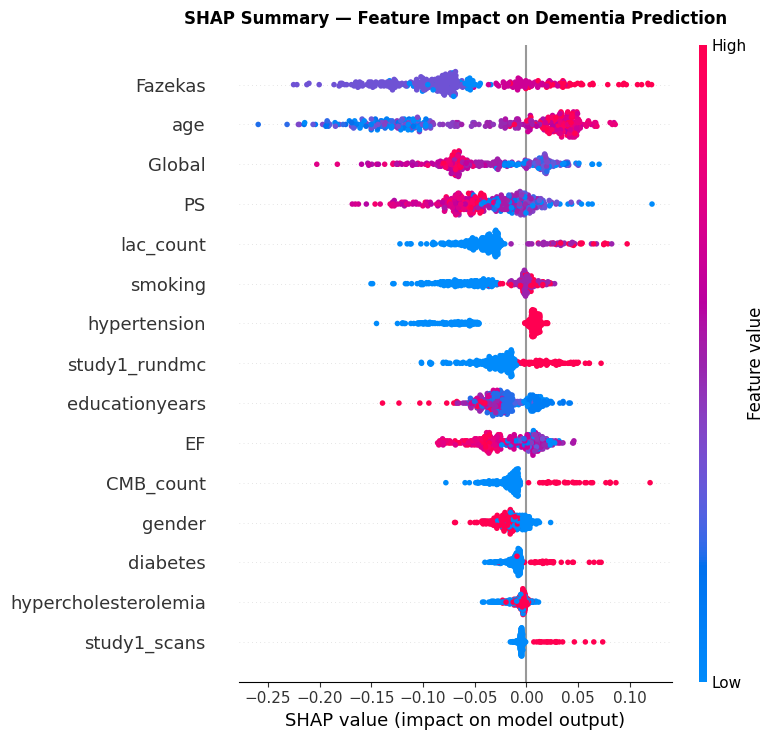

In [128]:
# SHAP beeswarm — shows importance AND direction of effect per feature
plt.figure(figsize=(10, 7))
shap.summary_plot(sv, X_test_best, show=False)
plt.title('SHAP Summary — Feature Impact on Dementia Prediction',
          fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('SHAP_summary.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

In [129]:
# Group-level SHAP contribution
feature_groups = {
    'Cognitive Function':        ['EF', 'PS', 'Global'],
    'SVD / MRI Markers':        ['Fazekas', 'lac_count', 'CMB_count'],
    'Lifestyle & Vascular Risk': ['diabetes', 'hypertension', 'hypercholesterolemia', 'smoking'],
    'Demographics':              ['age', 'gender', 'educationyears'],
    'Study Cohort':              ['study1_rundmc', 'study1_scans']
}

mean_abs_shap = pd.DataFrame({
    'Feature':       X_test_best.columns,
    'Mean_Abs_SHAP': np.abs(sv).mean(axis=0)
})

def get_group(feat):
    for group, feats in feature_groups.items():
        if feat in feats:
            return group
    return 'Other'

mean_abs_shap['Group'] = mean_abs_shap['Feature'].apply(get_group)
group_shap = mean_abs_shap.groupby('Group')['Mean_Abs_SHAP'].sum().sort_values(ascending=False)

print('SHAP by group:')
print(group_shap)
mean_abs_shap.to_csv('SHAP_feature_scores.csv', index=False)
group_shap.reset_index().to_csv('SHAP_group_scores.csv', index=False)

SHAP by group:
Group
SVD / MRI Markers            0.141890
Cognitive Function           0.120165
Demographics                 0.117523
Lifestyle & Vascular Risk    0.084905
Study Cohort                 0.034037
Name: Mean_Abs_SHAP, dtype: float64


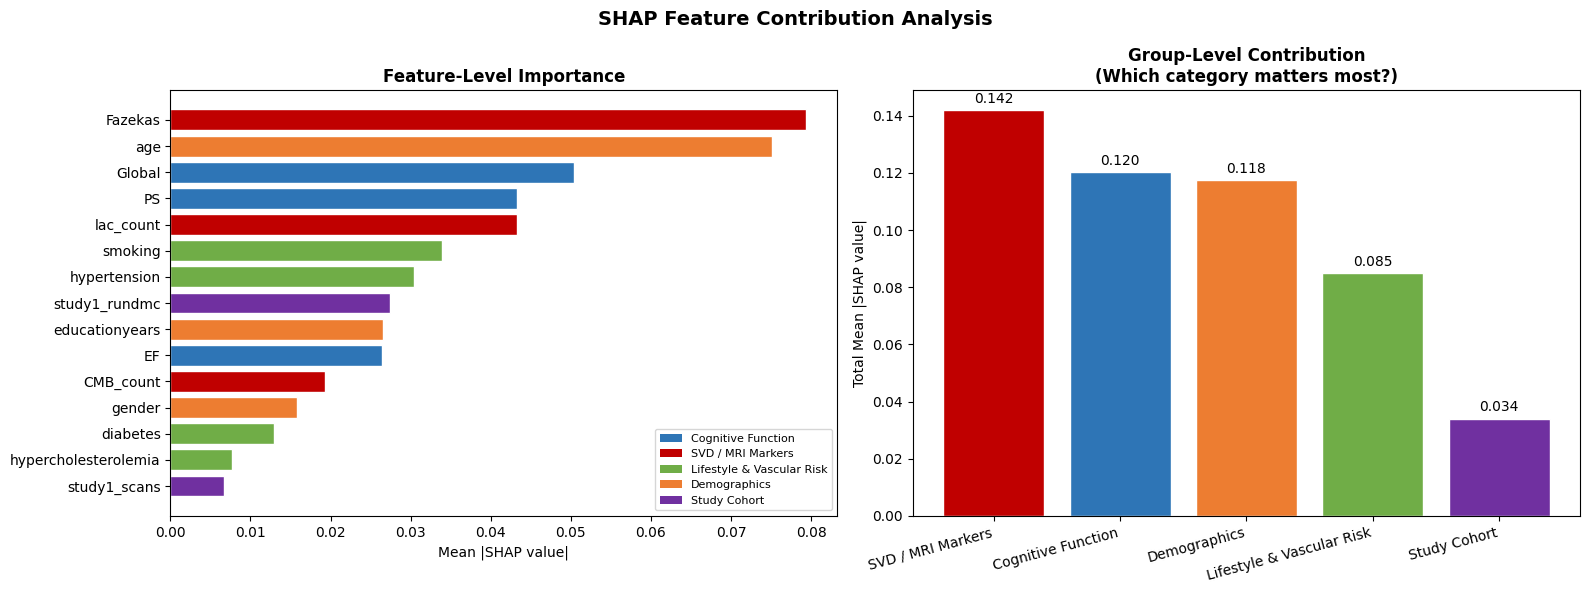

In [130]:
group_colors = {
    'Cognitive Function':        '#2E75B6',
    'SVD / MRI Markers':        '#C00000',
    'Lifestyle & Vascular Risk': '#70AD47',
    'Demographics':              '#ED7D31',
    'Study Cohort':              '#7030A0'
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('SHAP Feature Contribution Analysis', fontsize=14, fontweight='bold')

# Feature-level bar
ax = axes[0]
feat_sorted = mean_abs_shap.sort_values('Mean_Abs_SHAP', ascending=True)
bar_colors  = [group_colors.get(g, 'grey') for g in feat_sorted['Group']]
ax.barh(feat_sorted['Feature'], feat_sorted['Mean_Abs_SHAP'],
        color=bar_colors, edgecolor='white')
ax.set_xlabel('Mean |SHAP value|')
ax.set_title('Feature-Level Importance', fontweight='bold')
legend_elements = [Patch(facecolor=c, label=g) for g, c in group_colors.items()]
ax.legend(handles=legend_elements, fontsize=8, loc='lower right')

# Group-level bar
ax = axes[1]
g_colors = [group_colors.get(g, 'grey') for g in group_shap.index]
bars = ax.bar(range(len(group_shap)), group_shap.values,
              color=g_colors, edgecolor='white')
ax.set_xticks(range(len(group_shap)))
ax.set_xticklabels(group_shap.index, rotation=15, ha='right')
ax.set_ylabel('Total Mean |SHAP value|')
ax.set_title('Group-Level Contribution\n(Which category matters most?)', fontweight='bold')
ax.bar_label(bars, fmt='%.3f', padding=3)

plt.tight_layout()
plt.savefig('SHAP_group_analysis.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

## 8. Summary

In [131]:
print('='*55)
print('  GROUP 18 — MODELLING COMPLETE')
print('='*55)
print('\nCSV outputs saved:')
print('  LR_odds_ratios.csv')
print('  RF_feature_importance.csv')
print('  model_comparison.csv')
print('  SHAP_feature_scores.csv')
print('  SHAP_group_scores.csv')
print('\nPlots saved:')
print('  model_comparison.png')
print('  metrics_comparison.png')
print('  SHAP_summary.png')
print('  SHAP_group_analysis.png')
print('\n✅ Ready for report writing!')

  GROUP 18 — MODELLING COMPLETE

CSV outputs saved:
  LR_odds_ratios.csv
  RF_feature_importance.csv
  model_comparison.csv
  SHAP_feature_scores.csv
  SHAP_group_scores.csv

Plots saved:
  model_comparison.png
  metrics_comparison.png
  SHAP_summary.png
  SHAP_group_analysis.png

✅ Ready for report writing!


## Prediction

In [ ]:
# =============================================================
# 预测新病人
# =============================================================

def predict_patient(age, gender, educationyears, EF, PS, Global,
                    diabetes, hypertension, hypercholesterolemia,
                    smoking, Fazekas, lac_count, CMB_count,
                    study1_rundmc=0, study1_scans=0):
    """
    输入一个新病人的数据，返回痴呆风险预测。
    
    参数说明：
    - age: 年龄（数值）
    - gender: 性别（0=男, 1=女）
    - educationyears: 教育年限（数值）
    - EF: 执行功能评分
    - PS: 处理速度评分
    - Global: 全局认知评分
    - diabetes: 糖尿病（0=否, 1=是）
    - hypertension: 高血压（0=否, 1=是）
    - hypercholesterolemia: 高胆固醇（0=否, 1=是）
    - smoking: 吸烟（0=从不, 1=曾经, 2=现在）
    - Fazekas: 白质病变评分（0-3）
    - lac_count: 脑腔隙数量（0=无, 1=1-2个, 2=3-5个, 3=>5个）
    - CMB_count: 脑微出血（0=无, 1=有）
    - study1_rundmc: 是否来自 rundmc 队列（默认0）
    - study1_scans: 是否来自 scans 队列（默认0）
    """
    
    # 构建输入数据（RF 用全部特征）
    input_rf = pd.DataFrame([{
        'age': age, 'gender': gender, 'educationyears': educationyears,
        'EF': EF, 'PS': PS, 'Global': Global,
        'diabetes': diabetes, 'hypertension': hypertension,
        'hypercholesterolemia': hypercholesterolemia, 'smoking': smoking,
        'Fazekas': Fazekas, 'lac_count': lac_count, 'CMB_count': CMB_count,
        'study1_rundmc': study1_rundmc, 'study1_scans': study1_scans
    }])
    
    # LR 只用 Global（不含 EF/PS）
    input_lr = input_rf[X_test_lr.columns]
    
    # 标准化（用训练时的 scaler）
    input_rf_scaled = pd.DataFrame(
        scaler.transform(input_rf), columns=input_rf.columns)
    input_lr_scaled = input_rf_scaled[X_test_lr.columns]
    
    # 预测概率
    prob_lr = lr.predict_proba(input_lr_scaled)[0, 1]
    prob_rf = rf.predict_proba(input_rf_scaled)[0, 1]
    
    # 用各自的最优阈值做判断
    pred_lr = int(prob_lr >= 0.5)
    pred_rf = int(prob_rf >= best_threshold)   # 0.117
    
    print("=" * 45)
    print("  DEMENTIA RISK PREDICTION")
    print("=" * 45)
    print(f"\n  Logistic Regression:")
    print(f"    Probability : {prob_lr:.1%}")
    print(f"    Prediction  : {'⚠ HIGH RISK' if pred_lr else '✓ Low Risk'}")
    print(f"\n  Random Forest (tuned threshold=0.117):")
    print(f"    Probability : {prob_rf:.1%}")
    print(f"    Prediction  : {'⚠ HIGH RISK' if pred_rf else '✓ Low Risk'}")
    print("\n" + "=" * 45)
    print("  ⚠ For research purposes only.")
    print("  Not for clinical diagnosis.")
    print("=" * 45)
    
    return prob_lr, prob_rf


# --- 示例：预测一个高风险病人 ---
predict_patient(
    age=75, gender=0, educationyears=8,
    EF=-1.5, PS=-1.2, Global=-1.0,
    diabetes=1, hypertension=1, hypercholesterolemia=0,
    smoking=2, Fazekas=3, lac_count=2, CMB_count=1
)